In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [3]:
train = pd.read_csv("F:/Analytics Vidhya Hackathon/Time Series/Train_SU63ISt.csv")
test = pd.read_csv("F:/Analytics Vidhya Hackathon/Time Series/Test_0qrQsBZ.csv")
train_original = train.copy()
test_original = test.copy()

In [4]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [5]:
test.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


# Extracting Features

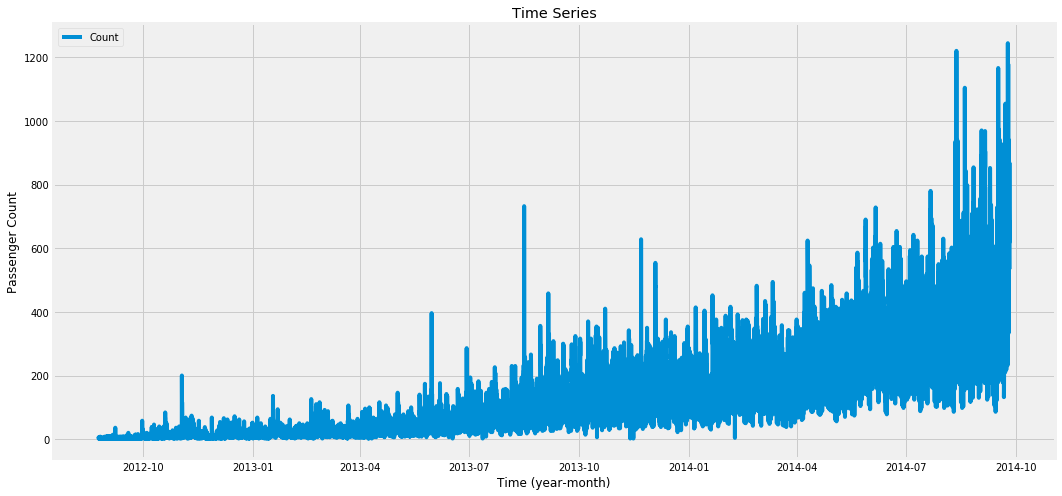

In [6]:
train['Datetime'] = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format = '%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format = '%d-%m-%Y %H:%M')

for i in (train, test, train_original, test_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day']= i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour
    
train['Day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
    
temp2 = train['Datetime'].apply(applyer)
train['weekend'] = temp2

train.index = train['Datetime']
df = train.drop('ID',1)
ts = df['Count']
plt.figure(figsize = (16,8))
plt.plot(ts)
plt.title("Time Series")
plt.xlabel("Time (year-month)")
plt.ylabel("Passenger Count")
plt.legend(loc = 'best')


test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index = test.Timestamp

#Converting to Daily mean 
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp

#Converting to Daily mean
train = train.resample('D').mean()

Train = train.ix['2012-08-25':'2014-06-24']
valid = train.ix['2014-06-25':'2014-09-25']

# Divide data into training and validation

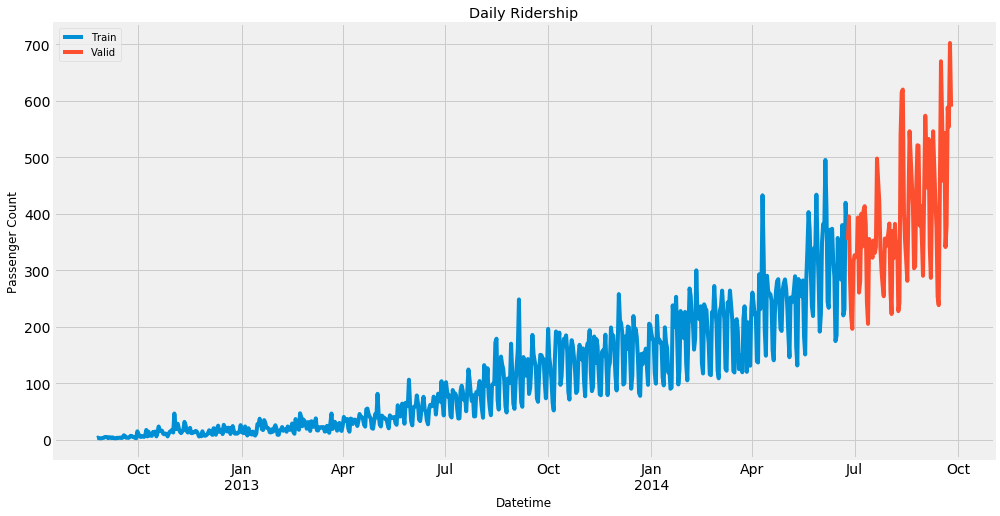

In [7]:
Train.Count.plot(figsize = (15,8), title = 'Daily Ridership', fontsize = 14, label = 'Train')
valid.Count.plot(figsize = (15,8), title = 'Daily Ridership', fontsize =14, label = 'Valid')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.legend(loc = 'best')

# Predicting Timeseries: Naive Approach

In this approach you're simply using the last data point to make a prediction.  Try modifying `y_hat['naive']` and see what happens. You could also try making it more complex or maybe even more Naive.

Text(0.5,1,'Naive Forecast')

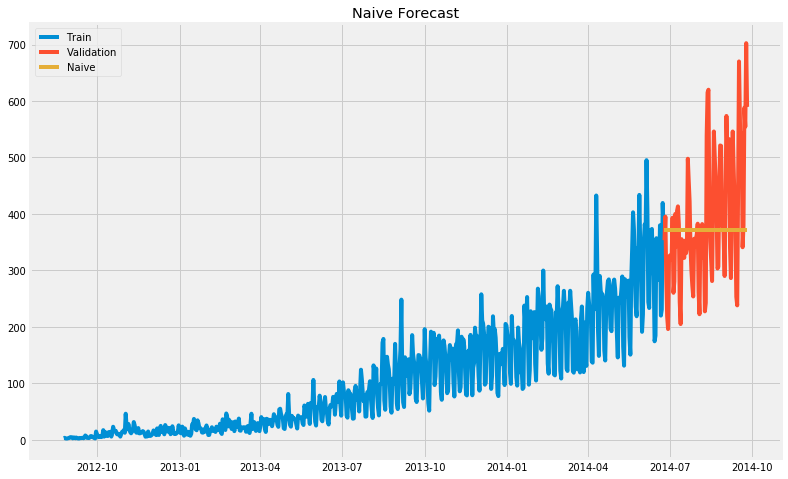

In [8]:
dd = np.asarray(Train.Count)
y_hat =valid.copy()
y_hat['naive']= dd[len(dd)- 1]
plt.figure(figsize = (12,8))
plt.plot(Train.index, Train['Count'],label = 'Train')
plt.plot(valid.index, valid['Count'], label = 'Validation')
plt.plot(y_hat.index, y_hat['naive'],  label = 'Naive')
plt.legend(loc = 'best')
plt.title('Naive Forecast')

### Calculate the RMSE for a Naive Approach

In [9]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(valid.Count, y_hat.naive))
rmse

111.79050467496724

In this section, try increasgin or decreasing the size of the rolling average widow to see how it affects your Naive predictions.

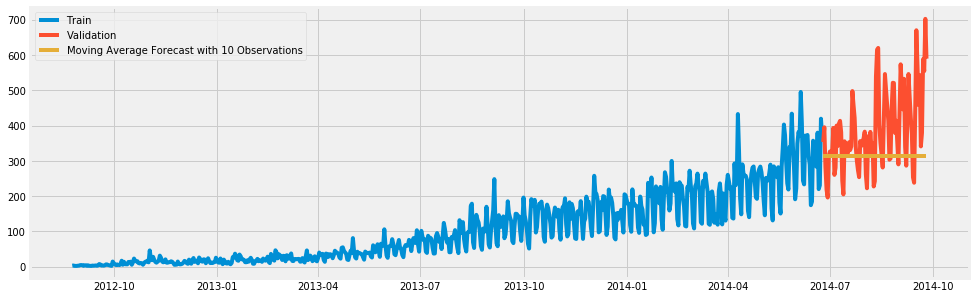

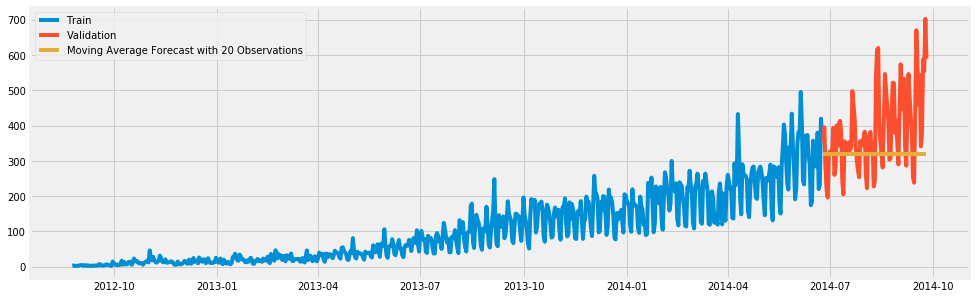

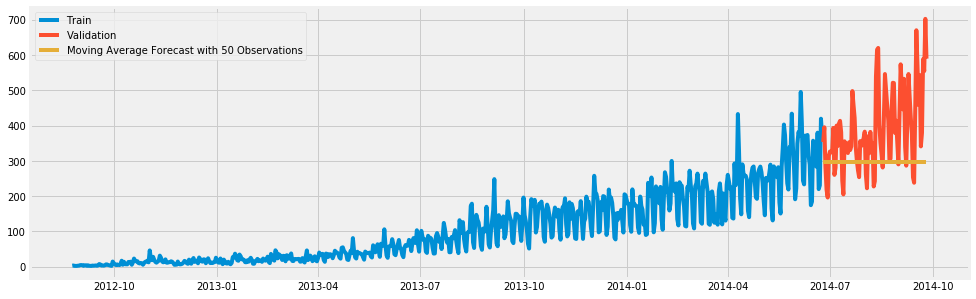

In [10]:
y_hat_avg = valid.copy()
y_hat_avg['moving_average_forecast'] = Train['Count'].rolling(10).mean().iloc[-1]
plt.figure(figsize = (15,5))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Validation')
plt.plot(y_hat_avg['moving_average_forecast'], label = 'Moving Average Forecast with 10 Observations')
plt.legend(loc = 'best')
plt.show()

y_hat_avg = valid.copy()
y_hat_avg['moving_average_forecast'] = Train['Count'].rolling(20).mean().iloc[-1]
plt.figure(figsize = (15,5))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Validation')
plt.plot(y_hat_avg['moving_average_forecast'],label = 'Moving Average Forecast with 20 Observations')
plt.legend(loc = 'best')
plt.show()

y_hat_avg = valid.copy()
y_hat_avg['moving_average_forecast']= Train['Count'].rolling(50).mean().iloc[-1]
plt.figure(figsize = (15,5))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Validation')
plt.plot(y_hat_avg['moving_average_forecast'], label = "Moving Average Forecast with 50 Observations")
plt.legend(loc = 'best')
plt.show()

### Calculate RMSE for a moving average

In [11]:
rmse = sqrt(mean_squared_error(valid['Count'], y_hat_avg['moving_average_forecast']))
rmse

144.19175679986802

# Predicting Timeseries: Simple Exponential Smoothing

Simple Exponential Smoothing is another fun method. Try out different for `smoothing_level` and `optimized`

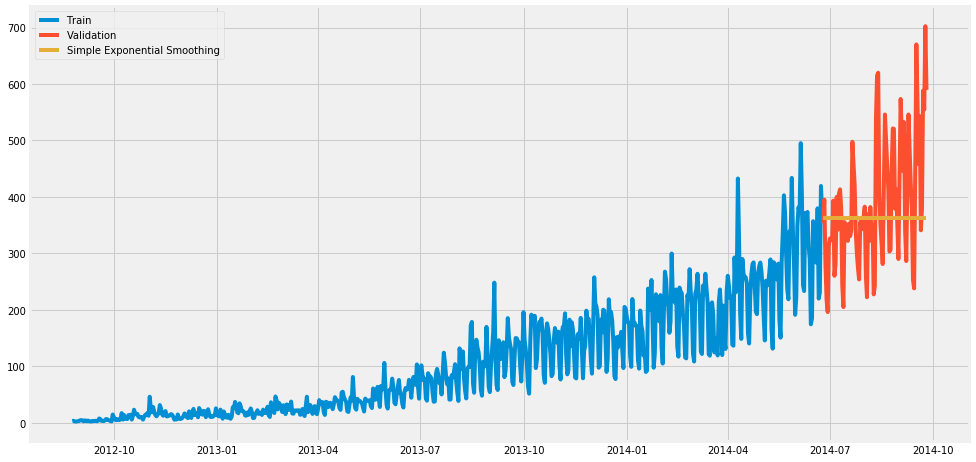

In [12]:
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt

y_hat = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level = 0.6,optimized = False)
y_hat['SES'] = fit2.forecast(len(valid))
plt.figure(figsize =(15,8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Validation')
plt.plot(y_hat['SES'], label = 'Simple Exponential Smoothing')
plt.legend(loc = 'best')


### Calculate RMSE for Simple Exponential Smoothing

In [13]:
rmse = sqrt(mean_squared_error(valid.Count, y_hat['SES']))
rmse

113.43708111884514

# Predicting Timeseris: Holt's Linear Trend Model

For this method, modify the `smoothing_level` and `smoothing_slope` parameters to see how it affects your predictions.

<Figure size 1600x800 with 0 Axes>

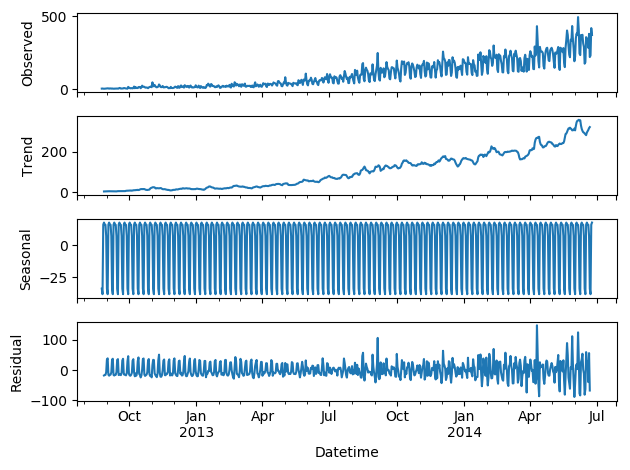

In [14]:
plt.style.use('default')
plt.figure(figsize = (16,8))
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

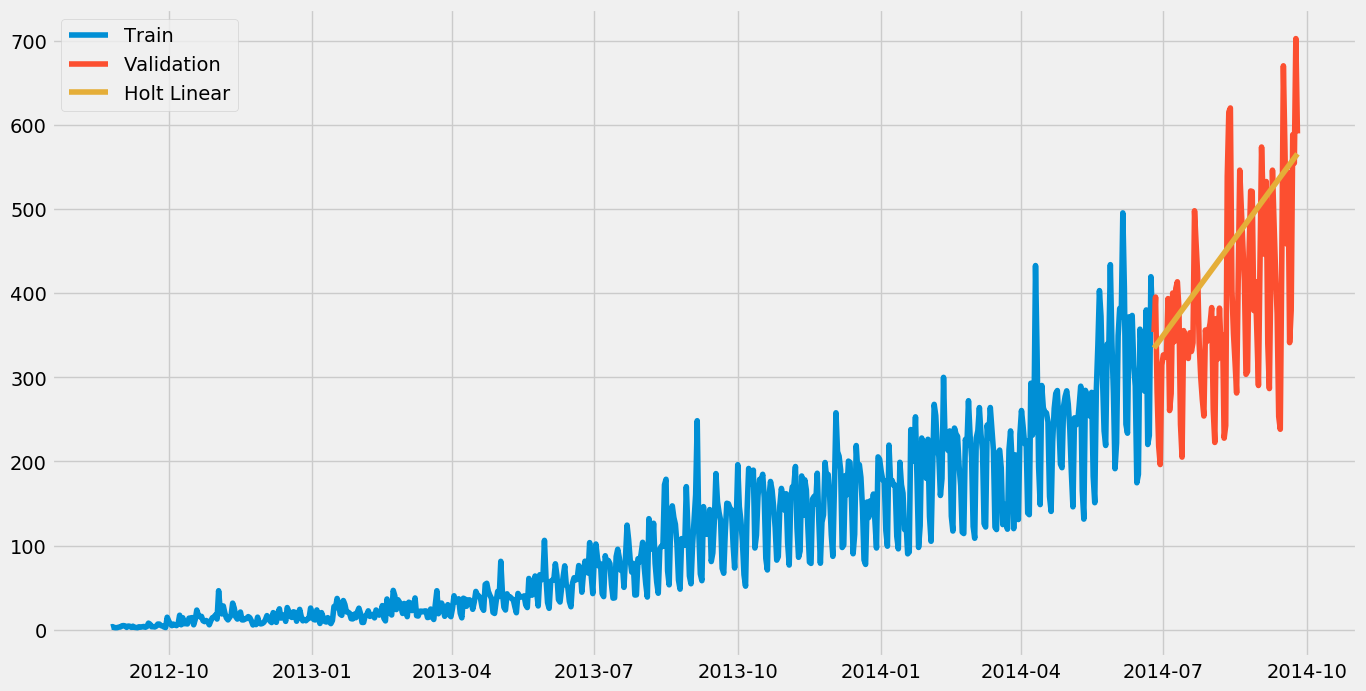

In [15]:
y_hat_holt = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
y_hat_holt['Holt_linear'] = fit1.forecast(len(valid))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,8))
plt.plot(Train.Count, label = 'Train')
plt.plot(valid.Count, label = 'Validation')
plt.plot(y_hat_holt['Holt_linear'], label = 'Holt Linear')
plt.legend(loc = 'best')

In [16]:
rmse = sqrt(mean_squared_error(valid.Count, y_hat_holt.Holt_linear))
rmse

112.94278345314041

In [17]:
predict = fit1.forecast(len(test))
test['prediction'] = predict

In [18]:
#Calculating hourly ration of count
train_original['ratio'] = train_original['Count']/train_original['Count'].sum()

#Grouping hourly ratio
temp = train_original.groupby(['Hour']) ['ratio'].sum()

#Group by to csv format
pd.DataFrame(temp, columns= ['Hour', 'ratio']).to_csv('Groupby.csv')
temp2 = pd.read_csv("Groupby.csv")
temp2 =temp2.drop('Hour.1',1)
#Merge test and test_original on day, month and year
merge = pd.merge(test, test_original, on = ('day', 'month','year'), how = 'left')
merge['Hour'] = merge['Hour_y']
merge = merge.drop(['year','month','day','Hour_x','Datetime','Hour_y'], axis =1)

#Predicting by merging temp2 and merge
prediction = pd.merge(merge, temp2, on = 'Hour',how = 'left')

#Converting the ration to original scale
prediction['Count'] = prediction['prediction'] * prediction['ratio'] * 24
prediction['ID'] = prediction['ID_y']
prediction.head()

,ID_x,prediction,ID_y,Hour,ratio,Count,ID
0,18299.5,334.650767,18288,0,0.044287,355.692974,18288
1,18299.5,334.650767,18289,1,0.035343,283.861602,18289
2,18299.5,334.650767,18290,2,0.029911,240.234347,18290
3,18299.5,334.650767,18291,3,0.024714,198.497058,18291
4,18299.5,334.650767,18292,4,0.020802,167.075574,18292


In [19]:
submission = prediction.drop(['ID_x','ID_y','prediction','Hour','ratio'], axis =1)
pd.DataFrame(submission, columns = ['ID','Count']).to_csv('Holt_Linear.csv')

# Predicting Timeseries: Holt Winter's Model

In this method, you can change the `ExponentialSmoothing` parameters. How many season_periods gives the best predictions?

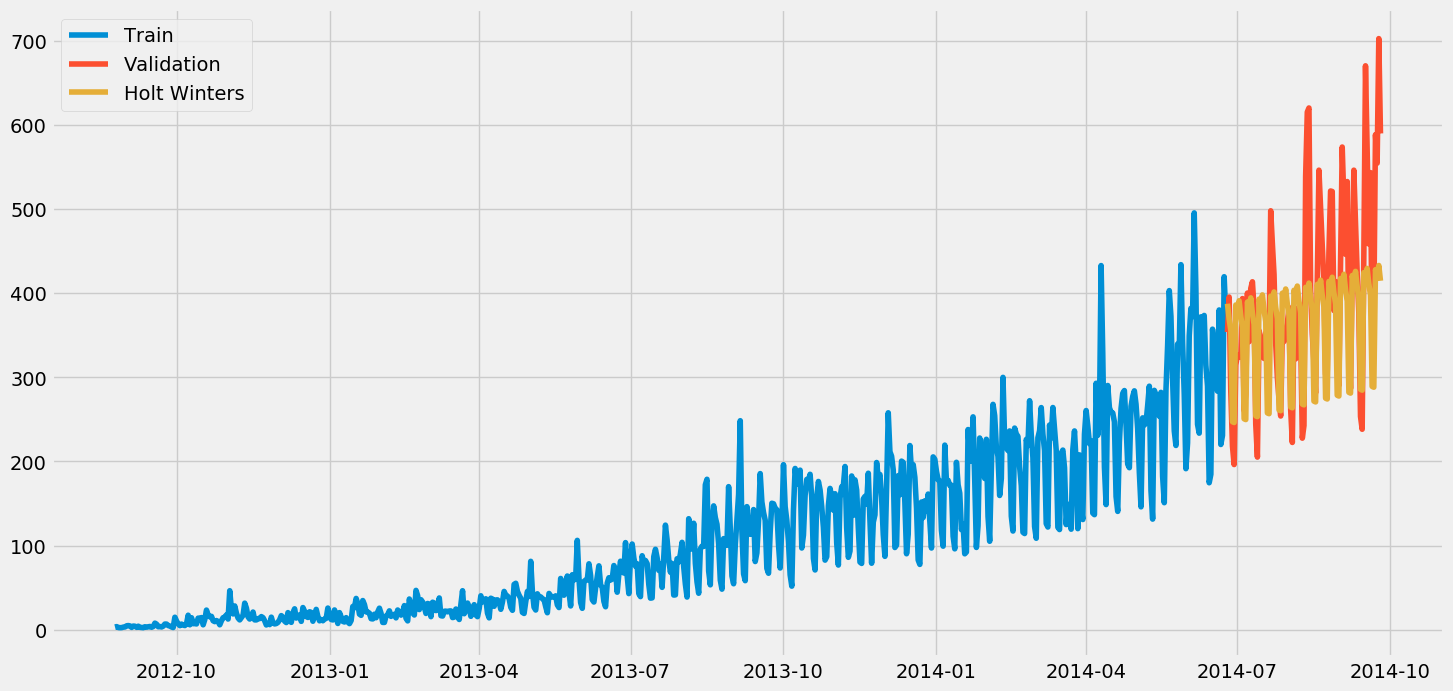

In [20]:
y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods= 7, trend = 'add', seasonal= 'add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize = (16,8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Validation')
plt.plot(y_hat_avg.Holt_Winter, label = 'Holt Winters')
plt.legend(loc = 'best')

In [21]:
rmse = sqrt(mean_squared_error(valid['Count'], y_hat_avg['Holt_Winter']))
rmse

82.37467736825413

In [22]:
predict = fit1.forecast(len(test))
test['prediction'] = predict

In [23]:
#Merge test and test_original on day,month and year
merge = pd.merge(test, test_original, on = ('day', 'month', 'year'), how = 'left')
merge['Hour']= merge['Hour_y']
merge.head()
merge = merge.drop(['year', 'month', 'Datetime','Hour_x', 'Hour_y'], axis =1)

#Predicting by merge and temp2
prediction = pd.merge(merge, temp2 , on = 'Hour', how = 'left')

#Converting the ration to original scale
prediction['Count'] = prediction['prediction'] * prediction['ratio'] *24
prediction.head()

,ID_x,day,prediction,ID_y,Hour,ratio,Count
0,18299.5,26.0,387.359889,18288,0,0.044287,411.716346
1,18299.5,26.0,387.359889,18289,1,0.035343,328.571184
2,18299.5,26.0,387.359889,18290,2,0.029911,278.072424
3,18299.5,26.0,387.359889,18291,3,0.024714,229.761310
4,18299.5,26.0,387.359889,18292,4,0.020802,193.390789


In [24]:
prediction['ID']= prediction['ID_y']
submission = prediction.drop(['ID_x','ID_y','day','Hour','prediction','ratio'], axis =1)

pd.DataFrame(submission, columns = ['ID','Count']).to_csv('Holt winters.csv')

# Predicting Time Series: ARIMA Model

Experiment with this ARIMA model by adjusting the rolling average and standard deviation windows. How do they affect the results of the Dickey-Fuller test? 

In [25]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    #Determine rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    #Plot rolling Statistics
    orig = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    
    #Perform Dickey Fuller test
    print("Results of Dickey Fuller test: ")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lag Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

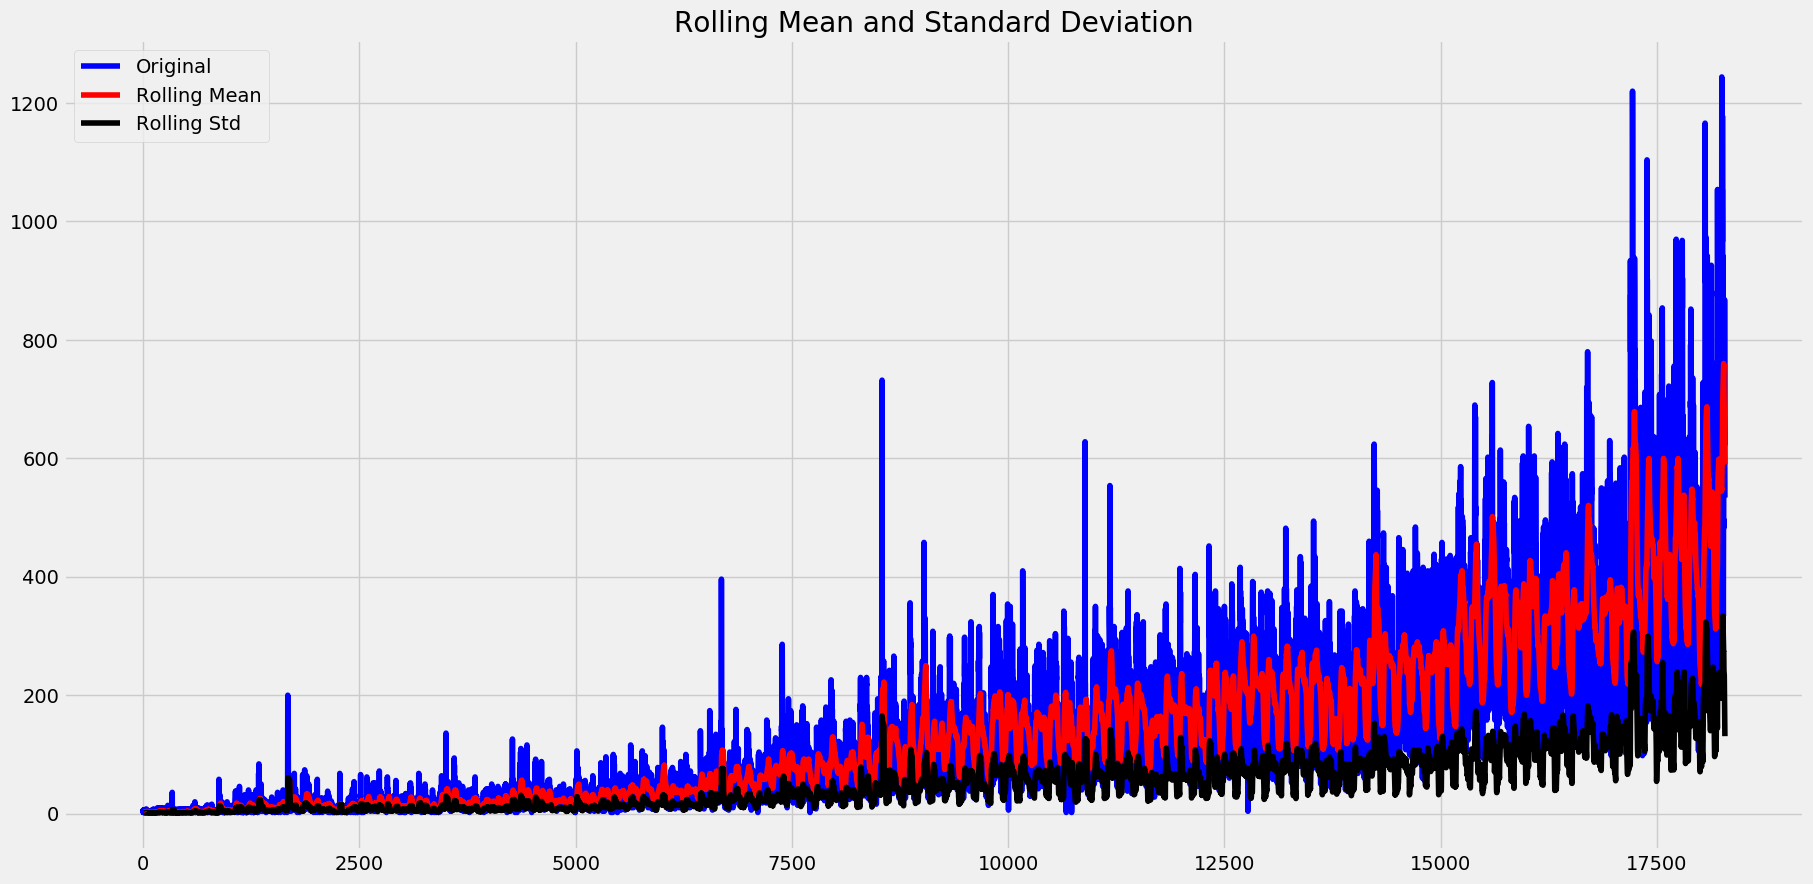

Results of Dickey Fuller test: 
Test Statistics                   -4.456561
p-value                            0.000235
# Lag Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=(20,10)
test_stationary(train_original['Count'])

### Remove trends

In [27]:
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

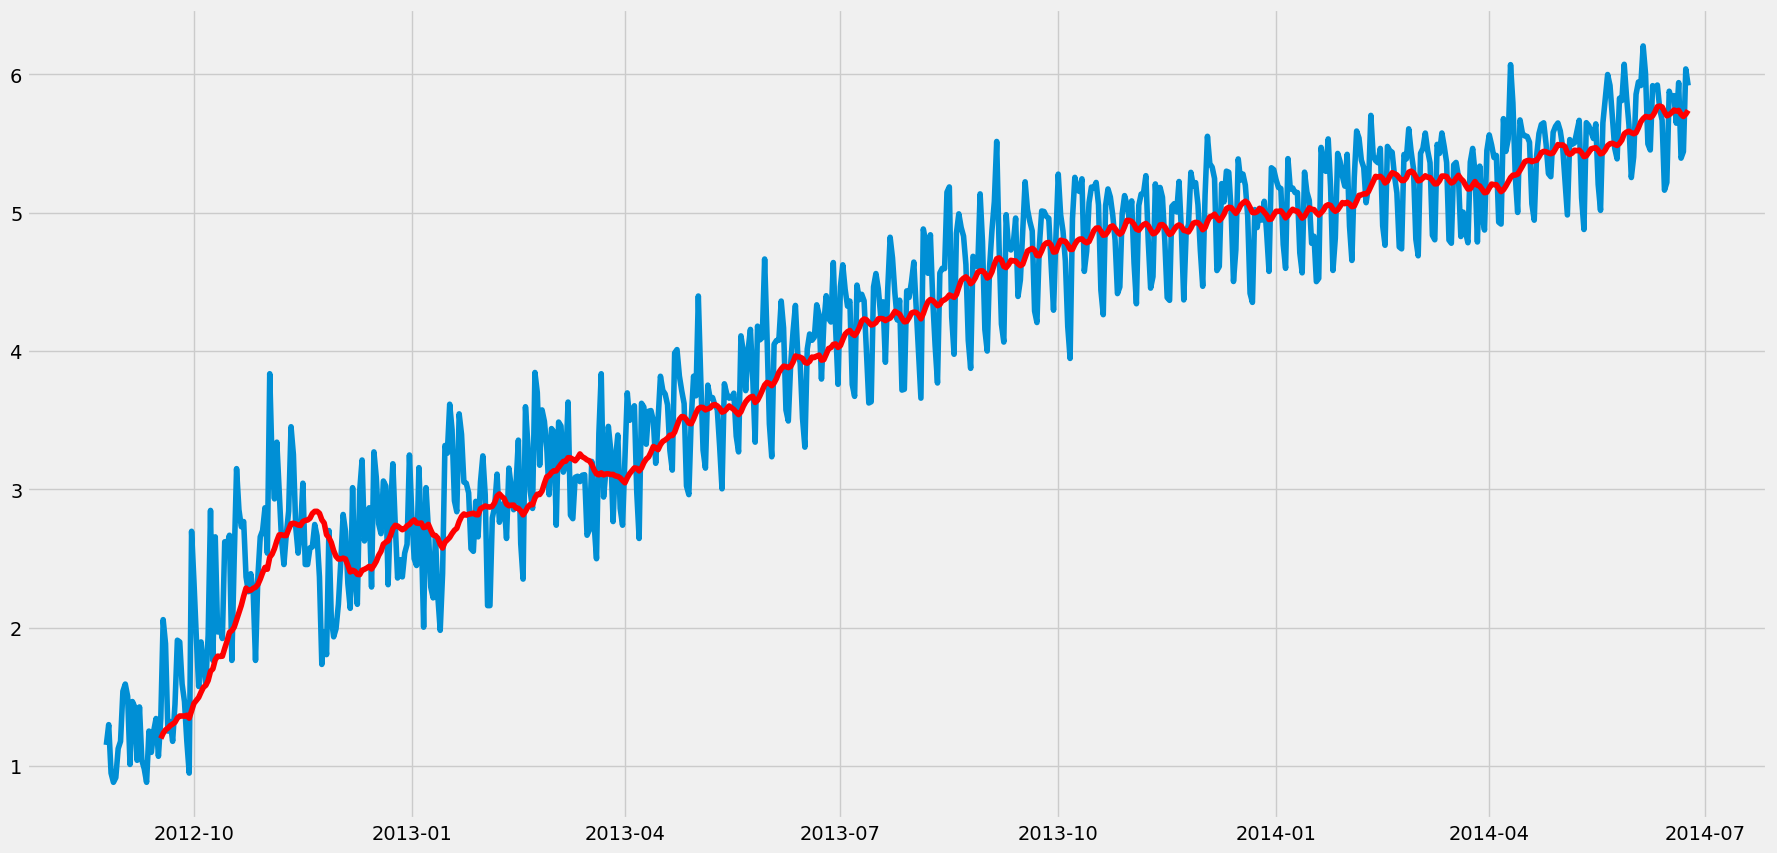

In [28]:
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')


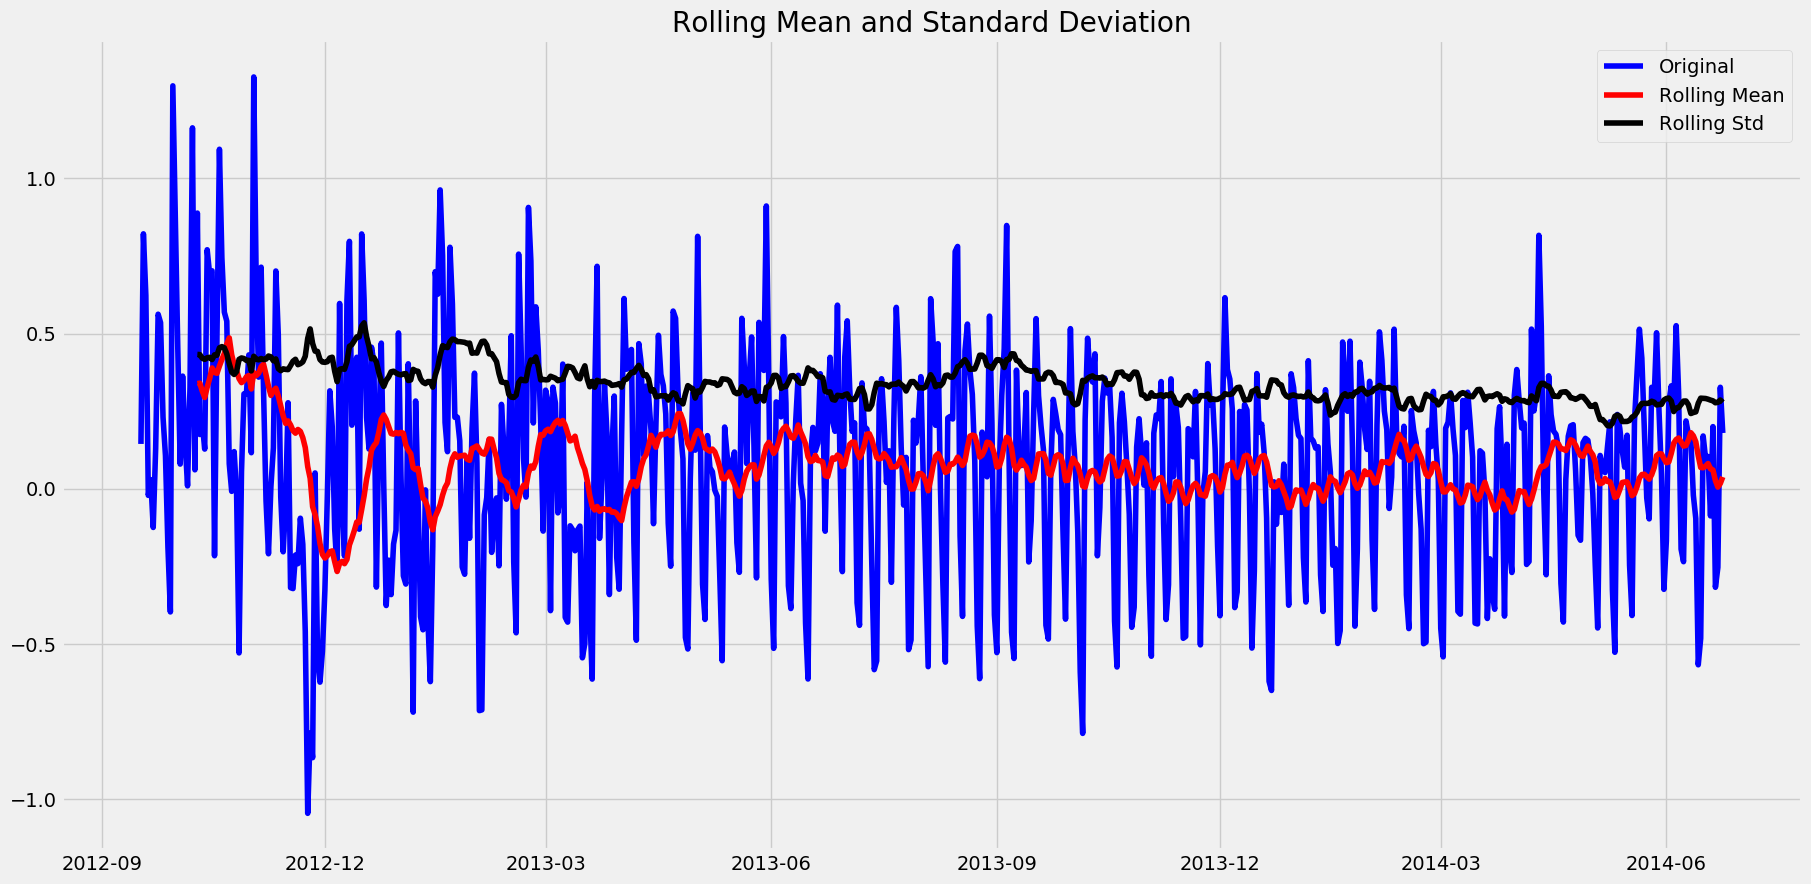

Results of Dickey Fuller test: 
Test Statistics               -5.861646e+00
p-value                        3.399422e-07
# Lag Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [29]:
train_log_moving_diff = Train_log - moving_avg
train_log_moving_diff.dropna(inplace = True)
test_stationary(train_log_moving_diff)

### Differencing can help to make the series stable and eliminate trends

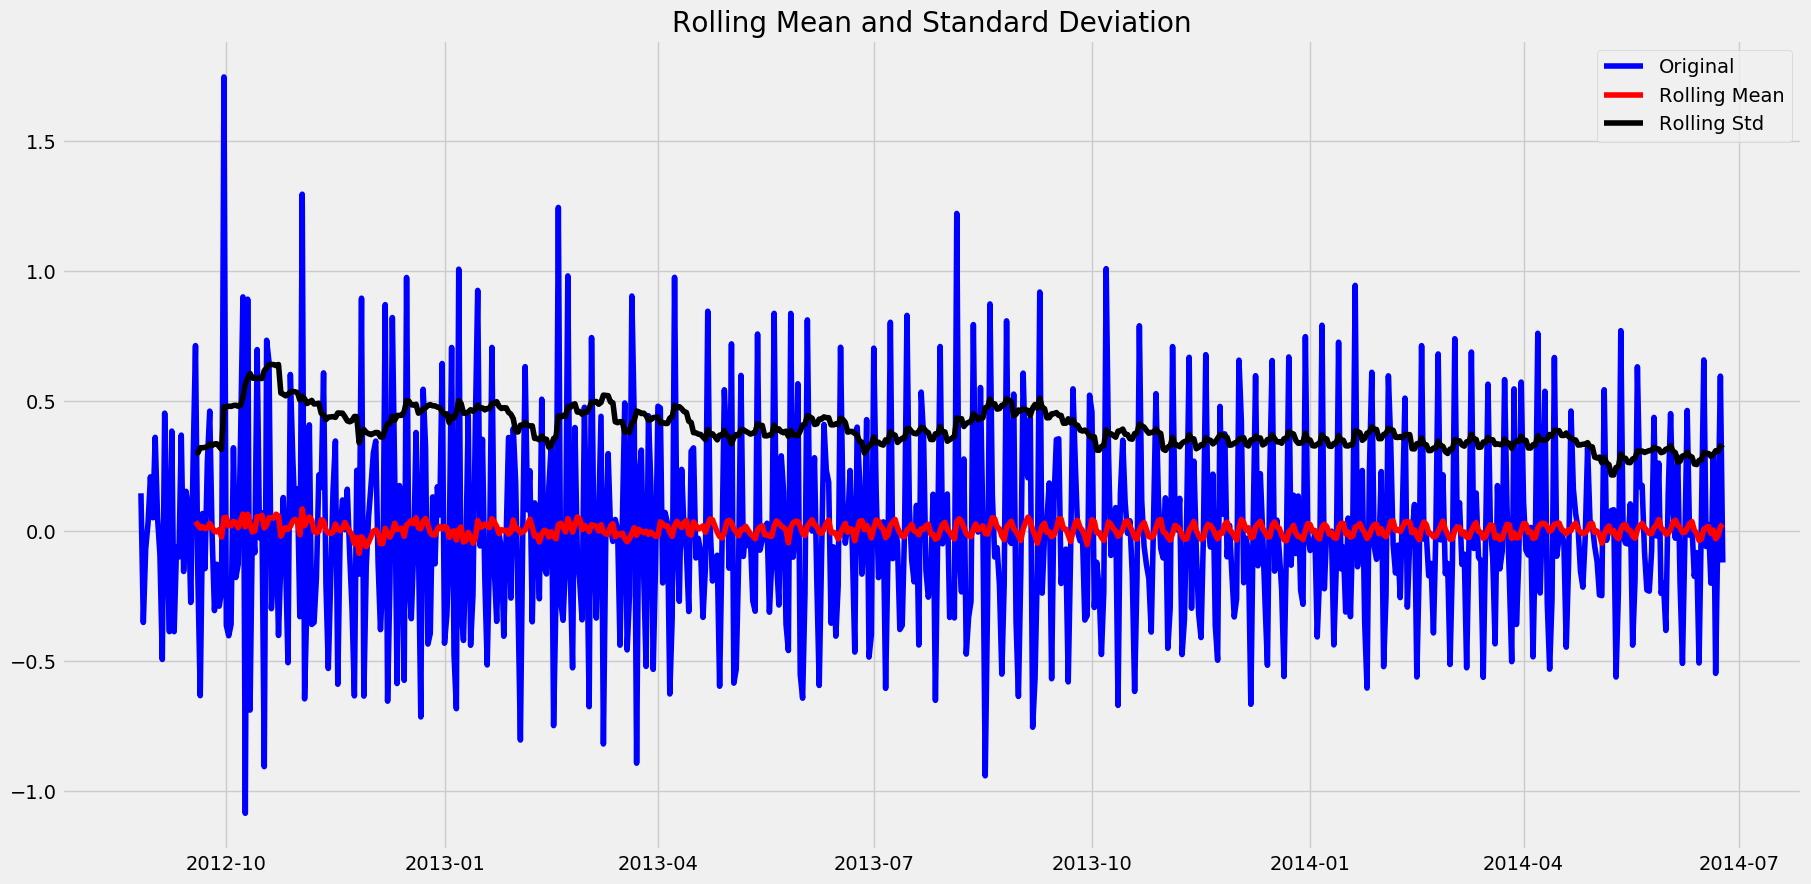

Results of Dickey Fuller test: 
Test Statistics               -8.237568e+00
p-value                        5.834049e-13
# Lag Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [30]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationary(train_log_diff.dropna())

### Removing Seasonailty

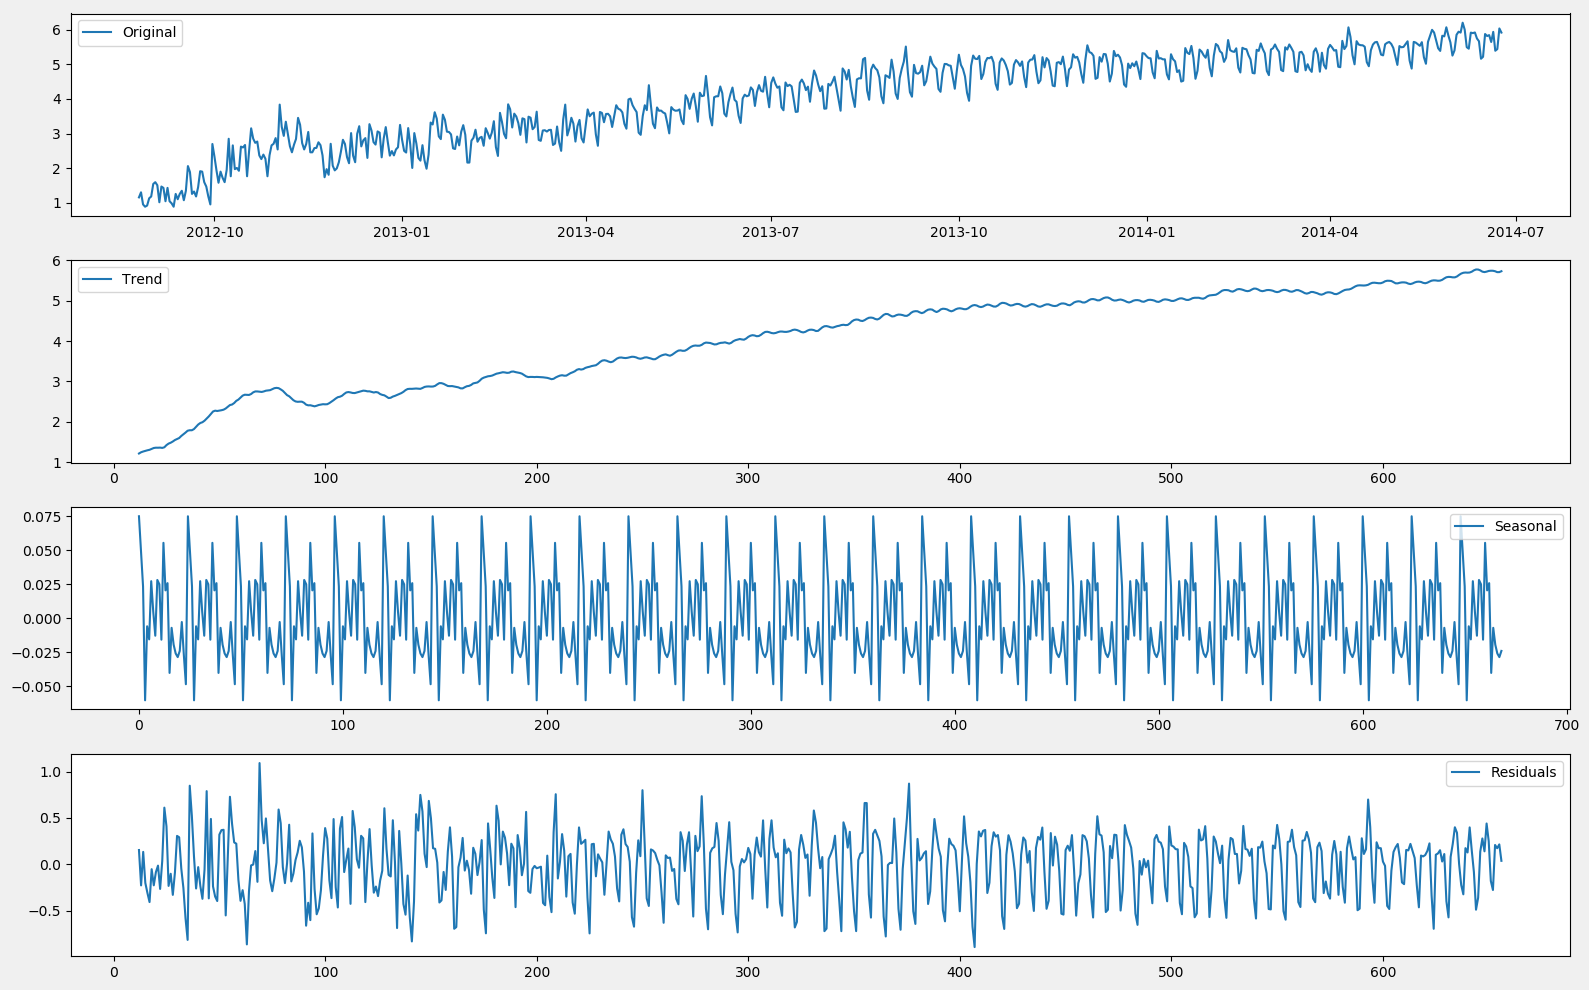

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize = (16,10))
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)
plt.style.use('default')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()


### Check stationarity of residuals

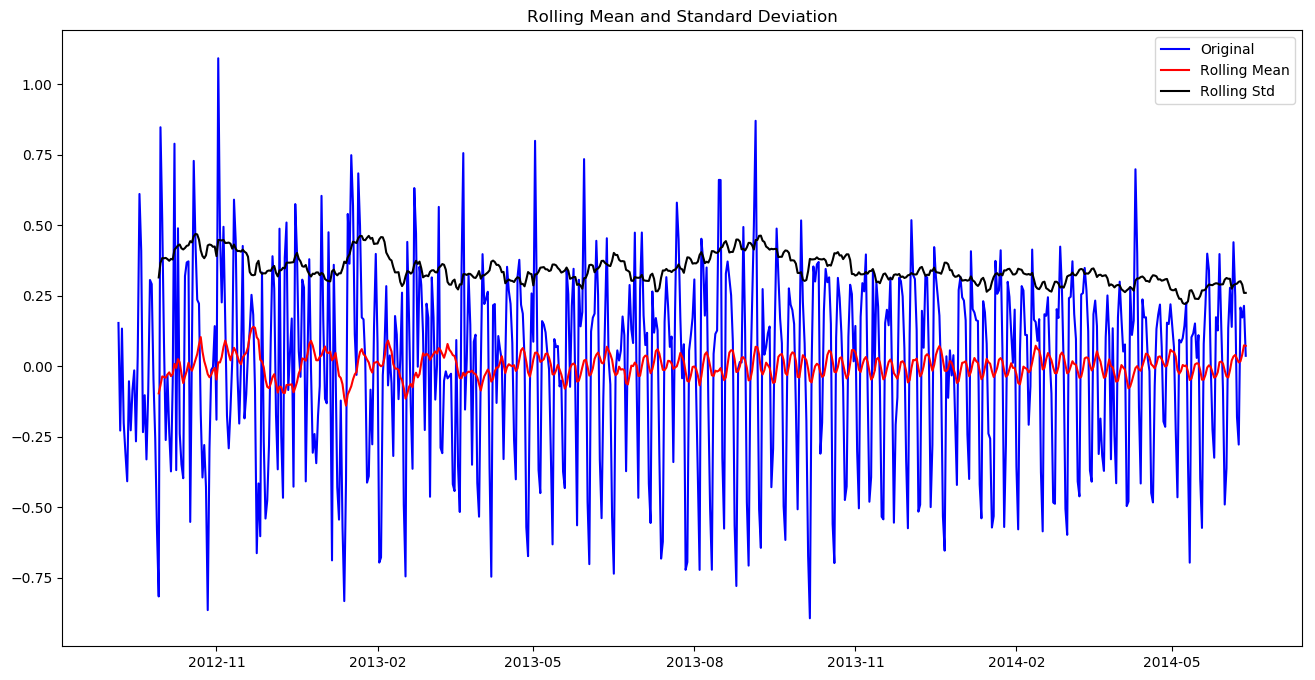

Results of Dickey Fuller test: 
Test Statistics               -7.822096e+00
p-value                        6.628321e-12
# Lag Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [32]:
plt.figure(figsize = (16,8))
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace = True)
test_stationary(train_log_decompose[0])

In [33]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_log_diff.dropna(), nlags = 25)
lag_pacf = pacf(train_log_diff.dropna(), nlags = 25, method= "ols")

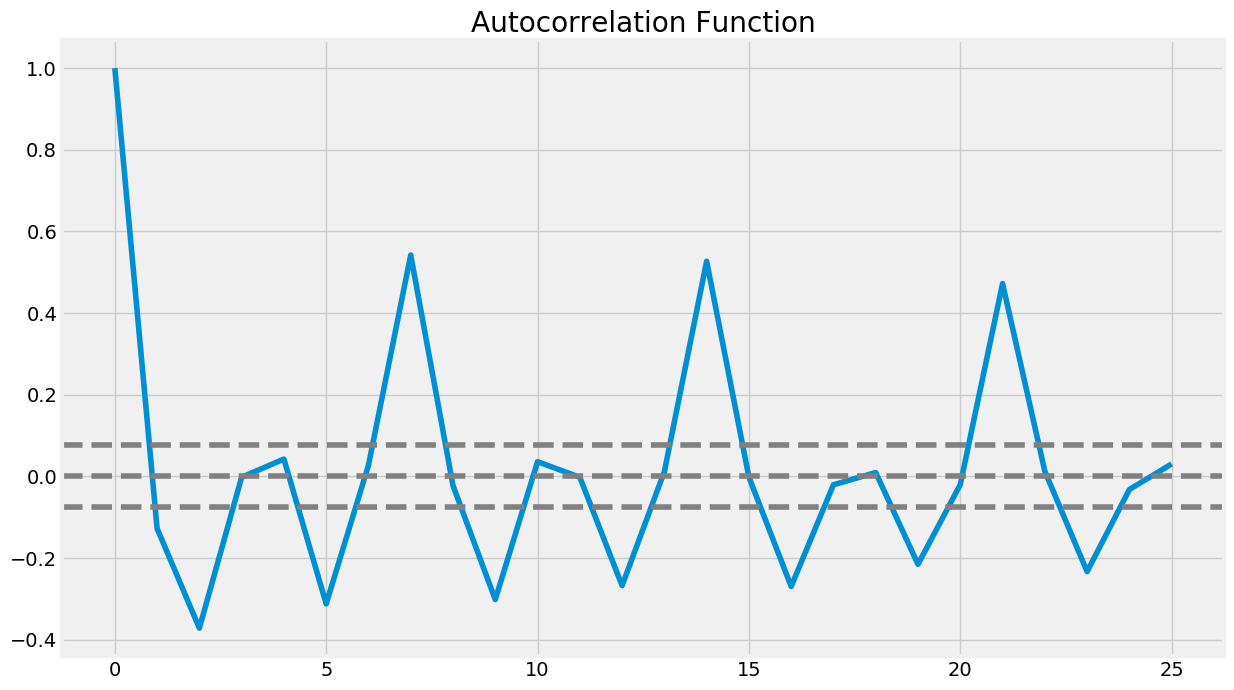

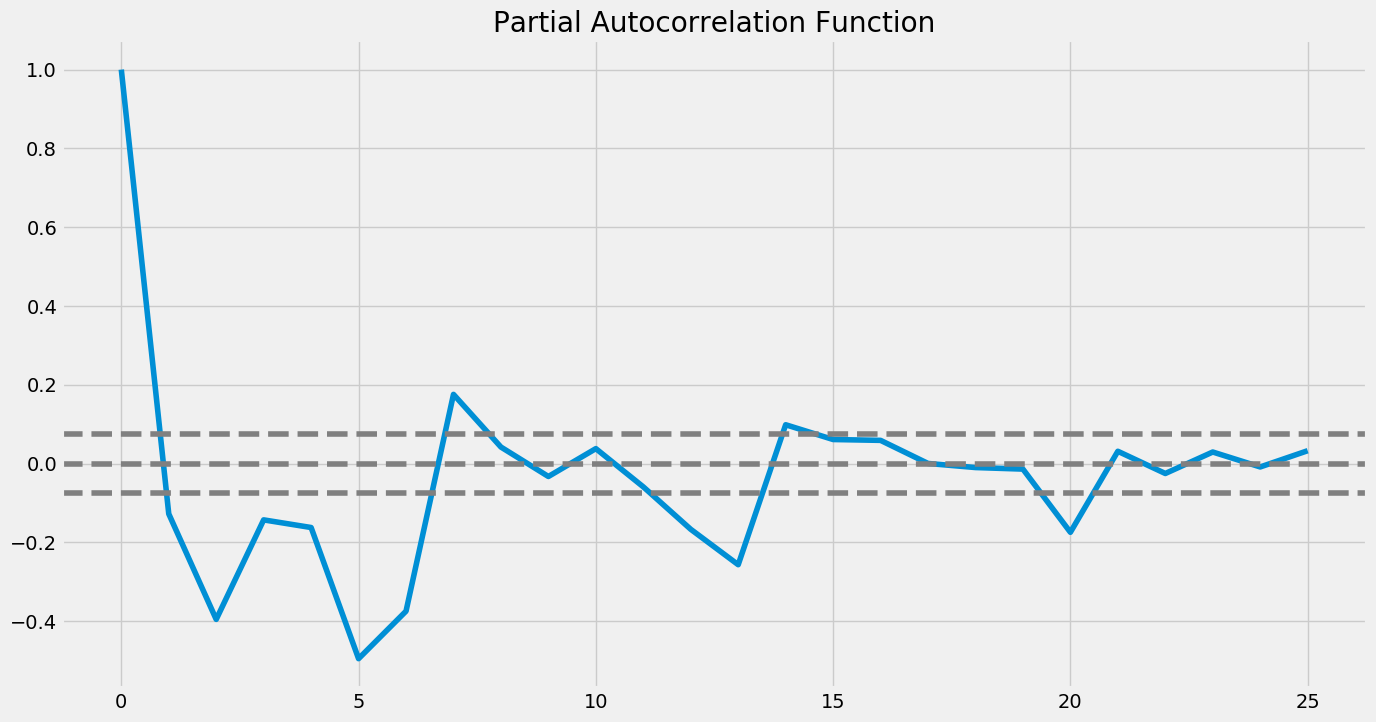

In [34]:
plt.figure(figsize = (15,8))
plt.style.use("fivethirtyeight")
plt.plot(lag_acf)
plt.axhline( y = 0, linestyle = "--", color = "gray")
plt.axhline( y= -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.axhline(y = 1.96 /np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.title("Autocorrelation Function")
plt.show()
# PACF
plt.figure(figsize = (15,8))
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = "--", color = "gray")
plt.axhline(y = -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.axhline( y = 1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.title("Partial Autocorrelation Function")
plt.show()

# Predicting Timeseries: AR Model

If you're unfamiliar with the ARIMA model, it might be helpful to see what parameters and arguments you can use to improve your predictions. Read up on `p,d,q`.<br> 
[https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html)

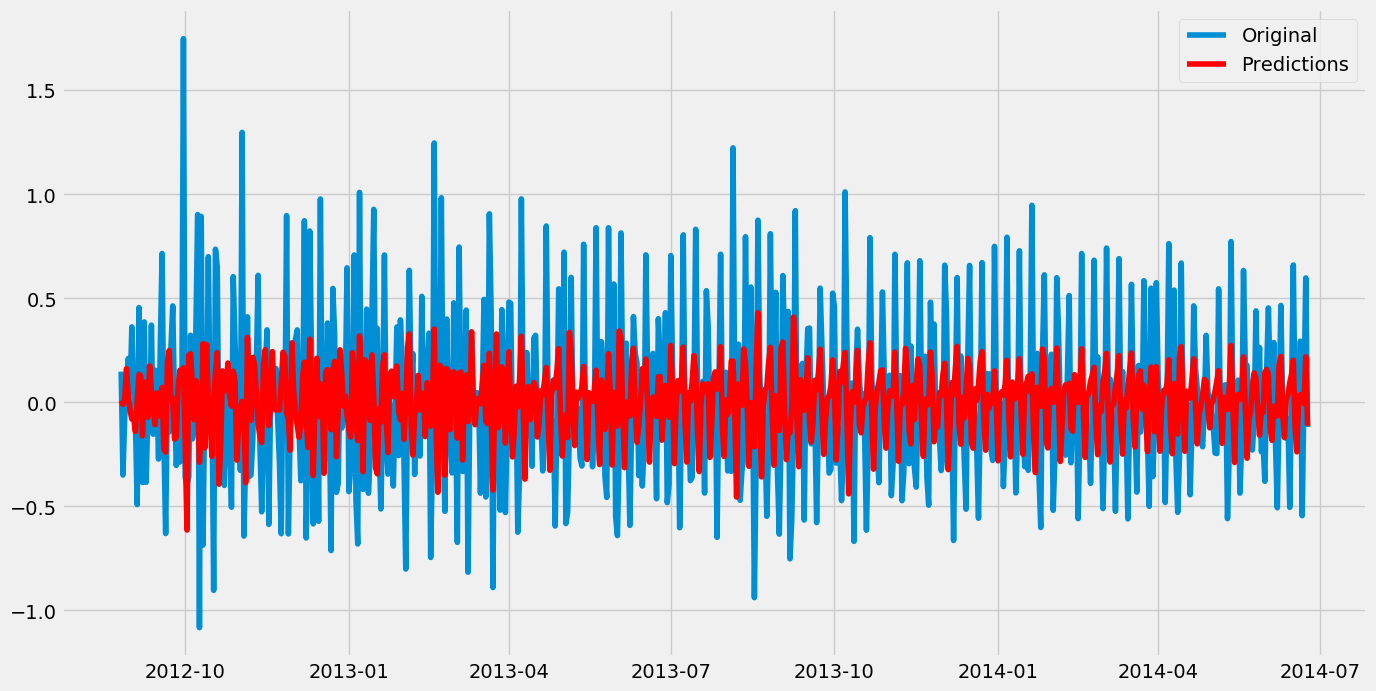

In [35]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize = (15,8))
model = ARIMA(Train_log, order = (2,1,0))  #here q value is zero since it is just AR Model
results_AR = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label = "Original")
plt.plot(results_AR.fittedvalues, color = 'red', label = 'Predictions')
plt.legend(loc = 'best')


In [36]:
AR_predict = results_AR.predict(start="2014-06-25", end="2014-09-25")
AR_predict = AR_predict.cumsum().shift().fillna(0)
AR_predict1 = pd.Series(np.ones(valid.shape[0])* np.log(valid['Count'])[0], index = valid.index)
AR_predict1=AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)

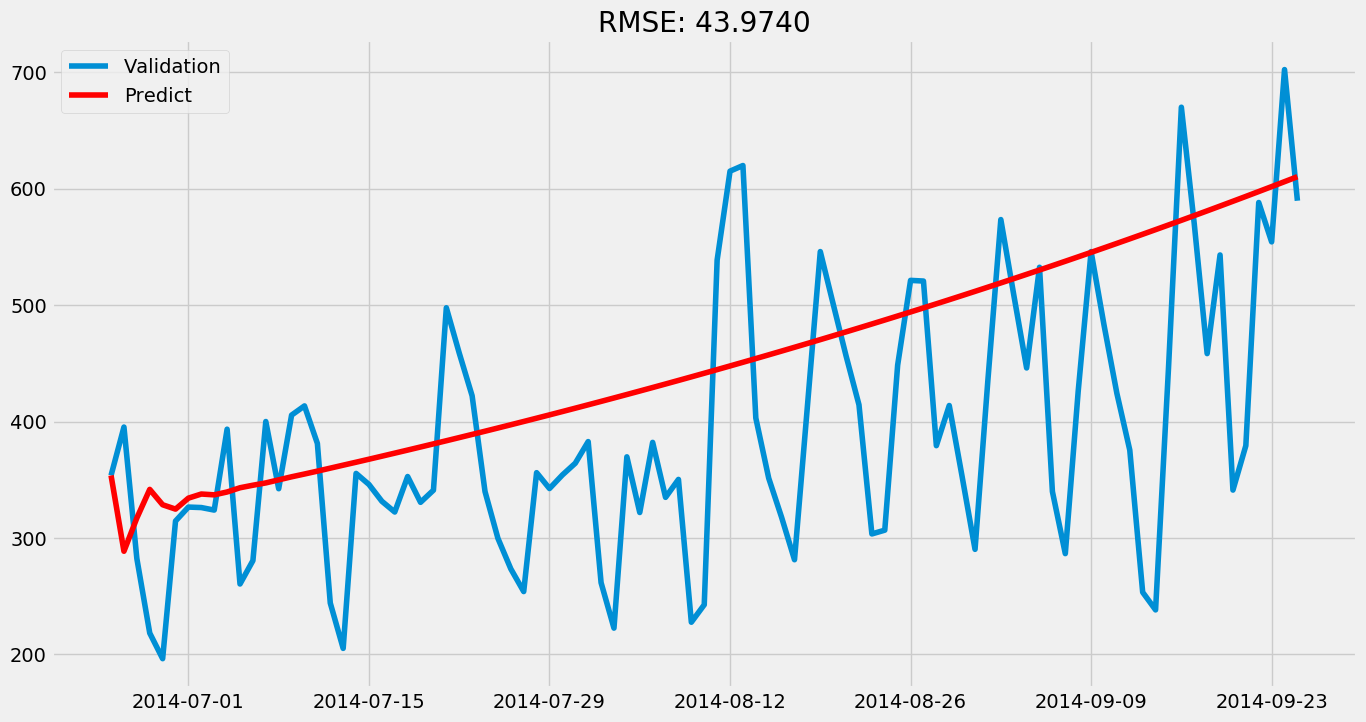

In [37]:
plt.figure(figsize = (15,8))
plt.plot(valid['Count'], label = "Validation")
plt.plot(AR_predict, color = "red", label = "Predict")
plt.legend(loc = "best")
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0]))
plt.show()

# Predicting Timeseries: Moving Average Model

For this model, you can modify the same parameters (p,d,q) because the base model relies on ARIMA.

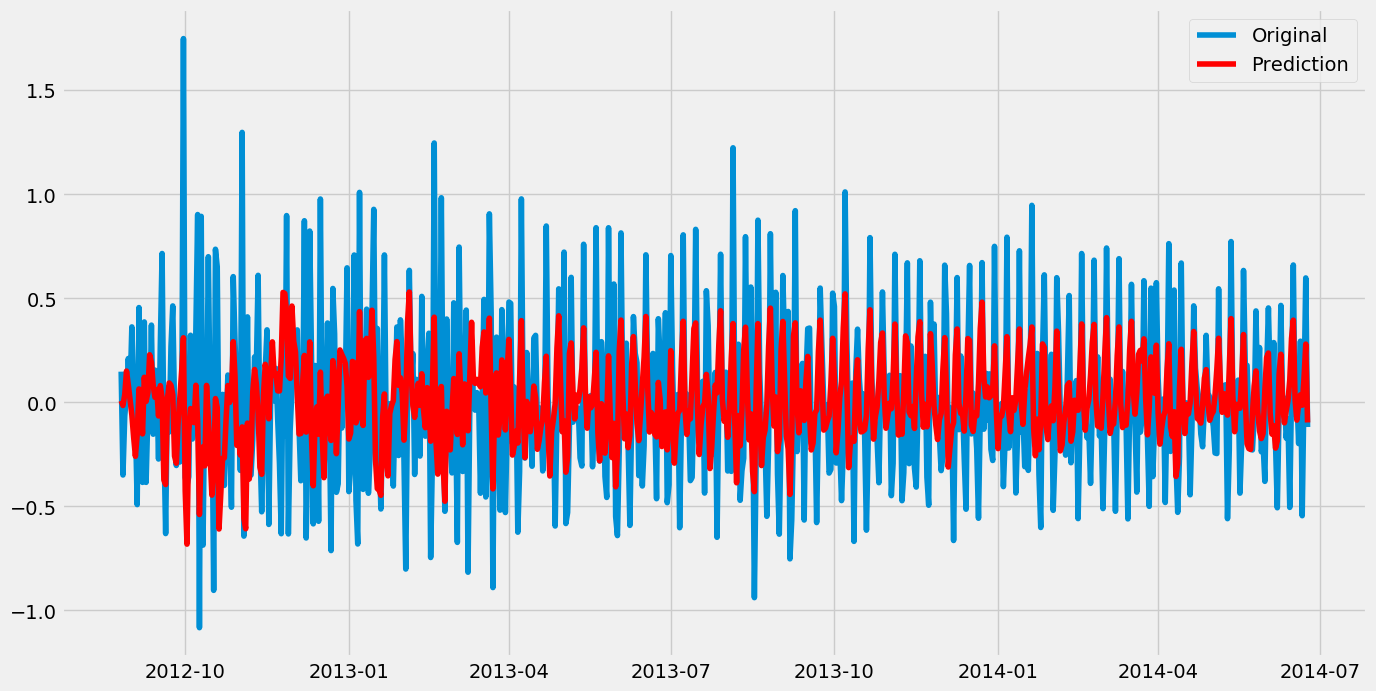

In [38]:
plt.figure(figsize = (15,8))
model = ARIMA(Train_log, order = (0,1,2)) # here the p value is 0 since it is moving average model
results_MA = model.fit(disp = -1)
plt.plot(train_log_diff.dropna(), label = "Original")
plt.plot(results_MA.fittedvalues, color = "red", label = "Prediction")
plt.legend(loc = "best")

In [39]:
MA_predict = results_MA.predict(start="2014-06-25", end="2014-09-25")
MA_predict=MA_predict.cumsum().shift().fillna(0)
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
MA_predict1=MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)

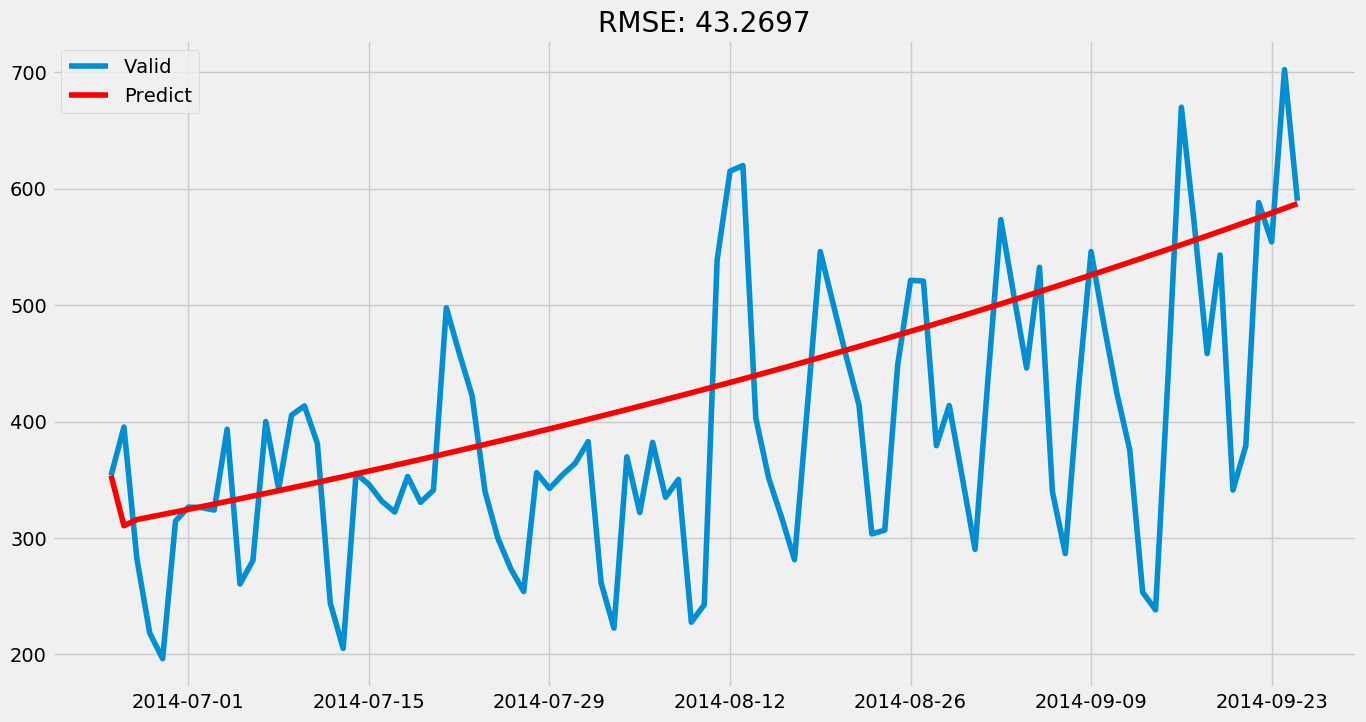

In [40]:
plt.figure(figsize = (15,8))
plt.plot(valid['Count'], label = "Valid")
plt.plot(MA_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0]))
plt.show()

### Combining Models

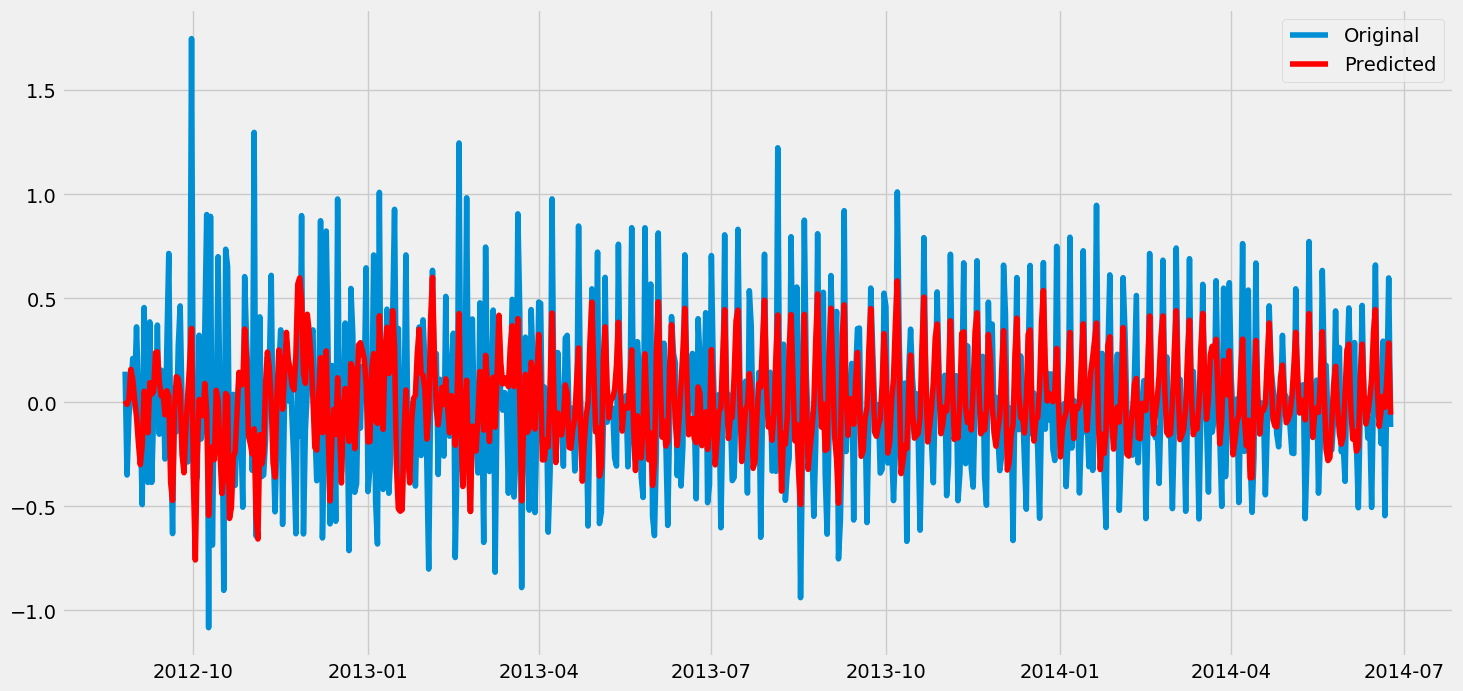

In [41]:
plt.figure(figsize = (16,8))
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='Original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.show()

### Scale model to original scale

In [42]:

def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [43]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [44]:
ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")

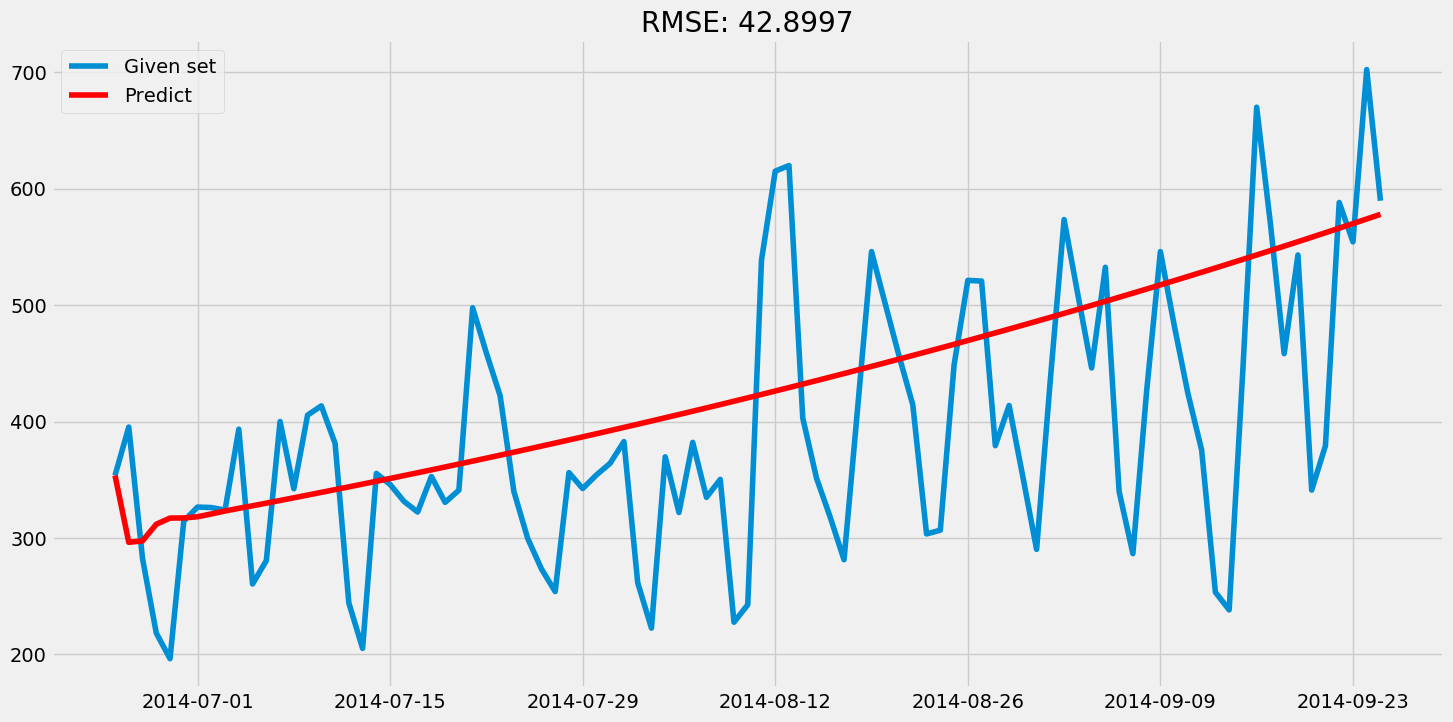

In [45]:
plt.figure(figsize = (16,8))
check_prediction_diff(ARIMA_predict_diff, valid)

# Predicting Timeseries: SARIMAX Model

By this point, you've probably got a pretty good idea about which parameters you can modify to make improvements to your predictions. Try out what you've learned using the SARIMAX model. 

In [46]:
import statsmodels.api as sm

C:\Users\SUNEEL\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'SARIMAX Model')

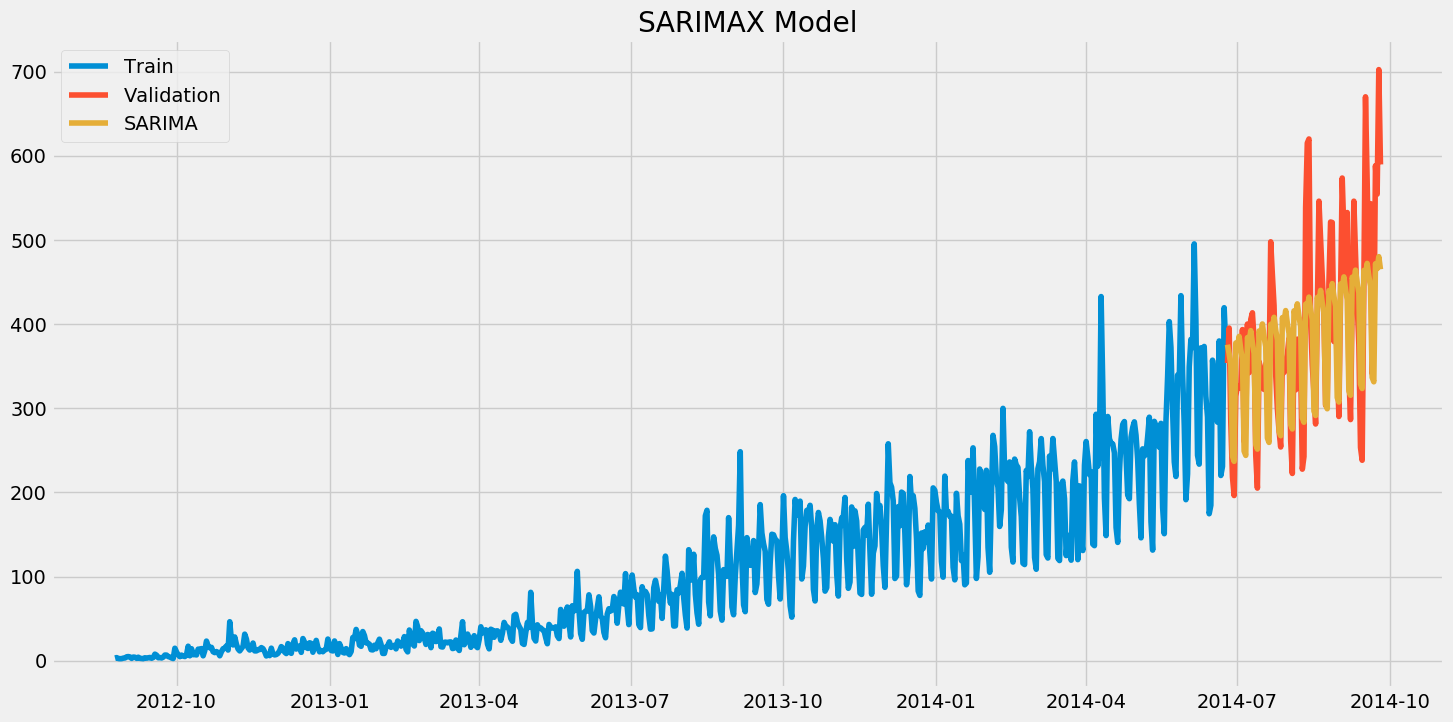

In [47]:
y_hat_avg = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order = (2,1,4), seasonal_order =(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label = "Train")
plt.plot(valid.Count, label = "Validation")
plt.plot(y_hat_avg['SARIMA'], label ="SARIMA")
plt.legend(loc = "best")
plt.title("SARIMAX Model")

In [48]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA))
print(rms)

70.01305241719037


### Covert to Hourly Predictions

In [49]:
predict = fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)

C:\Users\SUNEEL\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


In [50]:
test['prediction']=predict

In [51]:
#Merge test and test_original on day,month and year
merge = pd.merge(test,test_original, on = ('day', 'month', 'year'), how = 'left')
merge['Hour'] = merge['Hour_y']

#Predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on = 'Hour', how = 'left')

#Converting the ratio to original scale
prediction['Count'] = prediction['prediction'] * prediction['ratio'] * 24

In [52]:
prediction['ID']=prediction['ID_y']
submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)

# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')